[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/dougc333/Colab-Notebooks/blob/main/makemore_part3_part1.ipynb)


Makemore part3a there are no notes for part 1 or 2

Mzakemore part3a  /content/drive/MyDrive/Colab Notebooks/makemore_par1.ipynb

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

ValueError: mount failed

In [ ]:
%cd /content/drive/MyDrive/makemore
import os
os.chdir('/content/drive/My Drive/makemore')

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def enable_cuda():
  if torch.cuda.is_available():
    device = torch.device("cuda")        # NVIDIA GPU
  elif torch.backends.mps.is_available():
    device = torch.device("mps")         # Apple silicon GPU
  else:
    device = torch.device("cpu")         # CPU
  print(f"{device = }")



words = open('/content/drive/MyDrive/makemore/names.txt').read().splitlines()
print(words[:8])
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(f'vocab_size:{vocab_size}')

# build the dataset

def build_dataset(words,stoi):
  block_size = 3 # context length: how many characters do we take to predict the next one?
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X )
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1],stoi)     # 80%
Xdev, Ydev = build_dataset(words[n1:n2],stoi)   # 10%
Xte,  Yte  = build_dataset(words[n2:],stoi)     # 10%
# print("-"*30)
print(Xtr.shape,  Ytr.shape)
# print("-"*30)
print(Xdev.shape, Ydev.shape)
# print("-"*30)
print(Xte.shape,  Yte.shape)


['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
vocab_size:27
torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])
torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [ ]:
import random
random.seed(42)
import time

class FirstModel:
  def __init__(self):
    self.n_embed = 10
    self.n_hidden = 200
    self.block_size = 3
    self.device = self.enable_cuda()
    self.vocab_size, self.stoi, self.itos, self.words = self.get_data()
    self.split_data()

    self.g = torch.Generator(device=self.device).manual_seed(2147483647)
    #
    self.C = torch.randn(( self.vocab_size, self.n_embed),                 generator=self.g, device = self.device)
    self.W1 = torch.randn((self.n_embed * self.block_size, self.n_hidden), generator=self.g, device = self.device)
    self.b1 = torch.randn((self.n_hidden),                            generator=self.g, device = self.device)
    self.W2 = torch.randn((self.n_hidden, self.vocab_size),           generator=self.g, device = self.device)
    self.b2 = torch.randn( self.vocab_size,                           generator=self.g, device = self.device)
    self.parameters = [self.C, self.W1, self.b1, self.W2, self.b2]
    print(f'sum: sum(p.nelement() for p in self.parameteres)')

    for p in self.parameters:
      p.requires_grad = True

  def enable_cuda(self):
    if torch.cuda.is_available():
      device = torch.device("cuda")        # NVIDIA GPU
    elif torch.backends.mps.is_available():
      device = torch.device("mps")         # Apple silicon GPU
    else:
      device = torch.device("cpu")         # CPU
    print(f"{device = }")
    return device

  def get_data(self):
    words = open('/content/drive/MyDrive/makemore/names.txt').read().splitlines()
    # build the vocabulary of characters and mappings to/from integers
    chars = sorted(list(set(''.join(words))))
    stoi = {s:i+1 for i,s in enumerate(chars)}
    stoi['.'] = 0
    itos = {i:s for s,i in stoi.items()}
    vocab_size = len(itos)
    print(f'vocab_size:{vocab_size}')
    return vocab_size, stoi, itos, words

  def build_dataset(self, words):
    # context length: how many characters do we take to predict the next one?
    X, Y = [], []
    for w in words:
      context = [0] * self.block_size
      for ch in w + '.':
        ix = self.stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix] # crop and append

    X = torch.tensor(X, device = self.device)
    Y = torch.tensor(Y, device = self.device)
    return X, Y

  def split_data(self):
    random.seed(42)
    random.shuffle(self.words)

    n1 = int(0.8*len(self.words))
    n2 = int(0.9*len(self.words))

    self.Xtr,  self.Ytr  = self.build_dataset(self.words[:n1])     # 80%
    self.Xdev, self.Ydev = self.build_dataset(self.words[n1:n2])   # 10%
    self.Xte,  self.Yte  = self.build_dataset(self.words[n2:])     # 10%
    print(f"Xtr:{self.Xtr.shape} Ytr:{self.Ytr.shape}")
    print(f"Xdev:{self.Xdev.shape} Ydev:{self.Ydev.shape}")
    print(f"Xte:{self.Xte.shape} Yte:{self.Yte.shape}")


  def train(self):
    self.max_steps = 200000
    #self.max_steps=2
    self.batch_size = 32
    self.lossi = []
    start_time = time.time()

    for i in range(self.max_steps):
      #minibatch
      ix = torch.randint(0, self.Xtr.shape[0], (self.batch_size, ), generator=self.g , device = self.device)
      self.Xb, self.Yb = self.Xtr[ix], self.Ytr[ix]
      #print(f"Xb device:{self.Xb.device} Yb device:{self.Yb.device}")
      # forward
      self.emb = self.C[self.Xb]
      #print(f"self.emb device:{self.emb.device}")
      self.embcat = self.emb.view(self.emb.shape[0], -1)
      #print(f"self.embcat device:{self.embcat.device}")

      self.hpreact = self.embcat @ self.W1 + self.b1
      #print(f"self.hpreact device:{self.hpreact.device}")

      self.h = torch.tanh(self.hpreact)
      #print(f"self.h device:{self.h.device}")

      self.logits = self.h @ self.W2 + self.b2
      #print(f"self.logits device:{self.logits.device}")

      self.loss = F.cross_entropy(self.logits, self.Yb)
      #print(f"self.loss device:{self.loss.device}")

      #backward
      for p in self.parameters:
        p.grad = None
      self.loss.backward()
      # update
      lr = 0.1 if i < 100000 else 0.01
      for p in self.parameters:
        p.data += -lr * p.grad

      if i == 1:
        print(" i ==1 first iteration logits are further away from 0 than next example.")
        print("use this as an additional signal init is bad from karpathy 10.20. makemroe3")
        #print(f"logits:{self.logits}")
        print(f"see how close logits are to 0, mean:{self.logits.mean()}")

      if i % 10000 == 0:
        print(f'{i:7d}/{self.max_steps:7d}:{self.loss.item():.4f}')
      self.lossi.append(self.loss.log10().item()) # do we need to detach from GPU? prob not
    print(f"elapsed time:{time.time() - start_time}")

  def visualize(self):
    plt.plot(self.lossi)

  def inference(self):
    ''' gen output split_loss '''


fm = FirstModel()
fm.train()

#cuda t4 elapsed time:194.2956805229187
#cpu elapsed time:124.54593706130981

device = device(type='cpu')
vocab_size:27
Xtr:torch.Size([182625, 3]) Ytr:torch.Size([182625])
Xdev:torch.Size([22655, 3]) Ydev:torch.Size([22655])
Xte:torch.Size([22866, 3]) Yte:torch.Size([22866])
sum: sum(p.nelement() for p in self.parameteres)
      0/ 200000:27.8817
 i ==1 first iteration logits are further away from 0 than next example.
use this as an additional signal init is bad from karpathy 10.20. makemroe3
see how close logits are to 0, mean:1.154811143875122
  10000/ 200000:2.8341
  20000/ 200000:2.5523
  30000/ 200000:2.8717
  40000/ 200000:2.0855
  50000/ 200000:2.5842
  60000/ 200000:2.4150
  70000/ 200000:2.1321
  80000/ 200000:2.3674
  90000/ 200000:2.3077
 100000/ 200000:2.0464
 110000/ 200000:2.4816
 120000/ 200000:1.9383
 130000/ 200000:2.4820
 140000/ 200000:2.1662
 150000/ 200000:2.1765
 160000/ 200000:2.0685
 170000/ 200000:1.7901
 180000/ 200000:2.0546
 190000/ 200000:1.8380
elapsed time:123.39646244049072


In [ ]:
import torch
import time

class TestGPU:
  def __init__(self):
    self.device = torch.device('cpu')
    self.N, self.D_in, self.H,  self.D_out = 64, 1000, 100, 10
    self.x = torch.randn(self.N, self.D_in, device = self.device)
    self.y = torch.randn(self.N, self.D_out, device = self.device)
    self.w1 = torch.randn(self.D_in, self.H, device = self.device, requires_grad=True)
    self.w2 = torch.randn(self.H, self.D_out, device = self.device, requires_grad=True)
  def train(self):
    self.learning_rate = 1e-6
    start_time = time.time()
    for t in range(200000):
      y_pred = self.x.mm(self.w1).clamp(min=0).mm(self.w2)
      loss = (y_pred - self.y).pow(2).sum()
      if t%10000==0:
        print(t, loss.item())
      loss.backward()
      with torch.no_grad():
        self.w1 -= self.learning_rate * self.w1.grad
        self.w2 -= self.learning_rate * self.w2.grad

        self.w1.grad.zero_()
        self.w2.grad.zero_()
    print(f"elapsed time:{time.time() - start_time}")

t = TestGPU()
t.train()
# cpu elapsed time:107.3329873085022
# t4 elapsed time:115.09993624687195
# cant be correct

0 35094496.0
10000 1.8909810250988812e-07
20000 8.607058532561496e-08
30000 6.293406329405116e-08
40000 5.8722697815483116e-08
50000 5.03909873827979e-08
60000 5.2776204739757304e-08
70000 5.435846617274365e-08
80000 5.351009946252816e-08
90000 5.3093621943389735e-08
100000 5.109733791641702e-08
110000 5.38380895420687e-08
120000 5.2725461330282997e-08
130000 4.999849068099138e-08
140000 4.585929858080817e-08
150000 4.977005474415819e-08
160000 5.185821905229204e-08
170000 4.859023405856533e-08
180000 5.667277847010155e-08
190000 4.8145700759505416e-08
elapsed time:115.09993624687195


sum: sum(p.nelement() for p in self.parameteres)
      0/ 200000:28.5865
  10000/ 200000:2.9622
  20000/ 200000:2.2392
  30000/ 200000:2.7886
  40000/ 200000:2.1864
  50000/ 200000:2.7819
  60000/ 200000:2.5125
  70000/ 200000:2.2141
  80000/ 200000:2.4799
  90000/ 200000:2.1024
 100000/ 200000:2.6121
 110000/ 200000:1.6451
 120000/ 200000:2.1097
 130000/ 200000:2.0533
 140000/ 200000:2.1003
 150000/ 200000:2.1741
 160000/ 200000:1.7007
 170000/ 200000:2.2131
 180000/ 200000:2.0186
 190000/ 200000:2.1949


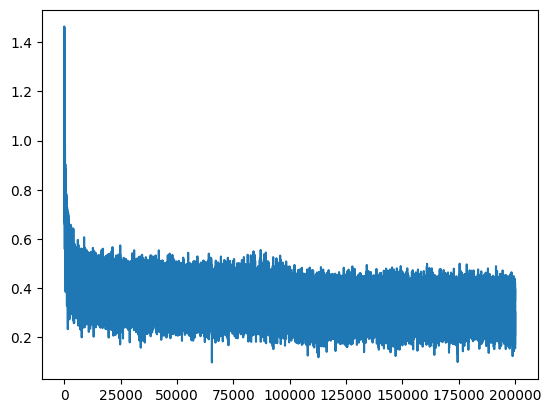

In [ ]:
fm.visualize()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

import time
from functools import wraps

def timeit(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        start = time.time()
        result = func(*args, **kwargs)
        end = time.time()
        print(f"⏱️ {func.__name__} took {end - start:.2f} seconds")
        return result
    return wrapper

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import torch
import torch.nn as nn
import torch.optim as optim
import time

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on: {device}")

# Large MLP
class BigMLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 2048),
            nn.ReLU(),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim)
        )

    def forward(self, x):
        return self.net(x)

# Model and data
model = BigMLP(input_dim=4096, output_dim=100).to(device)
batch_size = 4096
num_batches = 100

# Synthetic dataset (use real data in practice)
X = torch.randn(num_batches, batch_size, 4096).to(device)
Y = torch.randint(0, 100, (num_batches, batch_size)).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3)

# Timing
#torch.cuda.synchronize()
start = time.time()

# Training loop
model.train()
for epoch in range(5):
    total_loss = 0
    for i in range(num_batches):
        x = X[i]
        y = Y[i]

        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch}: avg loss = {total_loss / num_batches:.4f}")

#torch.cuda.synchronize()
end = time.time()
print(f"⏱️ Training time: {end - start:.2f} seconds")

# Running on: cuda
# Epoch 0: avg loss = 4.6056
# Epoch 1: avg loss = 4.6016
# Epoch 2: avg loss = 4.5609
# Epoch 3: avg loss = 4.5204
# Epoch 4: avg loss = 4.4667
# ⏱️ Training time: 26.98 seconds

# Running on: cpu
# Epoch 0: avg loss = 4.6057
# Epoch 1: avg loss = 4.6026
# Epoch 2: avg loss = 4.5733
# Epoch 3: avg loss = 4.5439
# Epoch 4: avg loss = 4.4775
# ⏱️ Training time: 411.12 seconds

Running on: cpu


<h2>strategy work from last layers to beginning so we can see the effect and not get stuck in cycles of ajustment. start from logits which are w2 abd b2. This doesnt work manually w more layers. </h2>

11:28 change the initialization to remove the hockey stick loss. Starting from high loss wastes training cycles. Multiply 0.1 to W2 and make b2=0.

device = device(type='cpu')
vocab_size:27
Xtr:torch.Size([182625, 3]) Ytr:torch.Size([182625])
Xdev:torch.Size([22655, 3]) Ydev:torch.Size([22655])
Xte:torch.Size([22866, 3]) Yte:torch.Size([22866])
sum: sum(p.nelement() for p in self.parameteres)
      0/ 200000:4.2326
logits are closer to 0 from karpathy makemroe3 YT video time index:10.20. 
see how close logits are to 0, mean:0.09495196491479874
  10000/ 200000:2.1403
  20000/ 200000:2.4720
  30000/ 200000:2.5577
  40000/ 200000:2.0154
  50000/ 200000:2.4307
  60000/ 200000:2.3385
  70000/ 200000:2.0680
  80000/ 200000:2.2665
  90000/ 200000:2.1172
 100000/ 200000:1.9299
 110000/ 200000:2.0630
 120000/ 200000:1.8901
 130000/ 200000:2.3980
 140000/ 200000:2.2826
 150000/ 200000:2.1250
 160000/ 200000:1.8469
 170000/ 200000:1.7627
 180000/ 200000:1.9119
 190000/ 200000:1.8235
elapsed time:118.07344698905945
train 2.0681493282318115
val 2.132511615753174


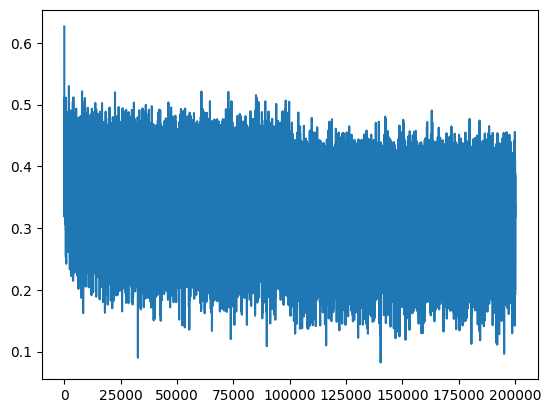

In [ ]:
import random
random.seed(42)
import time

class FirstModel:
  def __init__(self, debug_h=False):
    self.n_embed = 10
    self.n_hidden = 200
    self.block_size = 3
    self.device = self.enable_cuda()
    self.vocab_size, self.stoi, self.itos, self.words = self.get_data()
    self.split_data()
    self.debug_h = debug_h
    self.g = torch.Generator(device=self.device).manual_seed(2147483647)
    #
    self.C = torch.randn(( self.vocab_size, self.n_embed),                 generator=self.g, device = self.device)
    self.W1 = torch.randn((self.n_embed * self.block_size, self.n_hidden), generator=self.g, device = self.device)
    self.b1 = torch.randn((self.n_hidden),                            generator=self.g, device = self.device)
    self.W2 = torch.randn((self.n_hidden, self.vocab_size),           generator=self.g, device = self.device) * 0.1
    self.b2 = torch.randn( self.vocab_size,                           generator=self.g, device = self.device) * 0.
    self.parameters = [self.C, self.W1, self.b1, self.W2, self.b2]
    print(f'sum: sum(p.nelement() for p in self.parameteres)')

    for p in self.parameters:
      p.requires_grad = True

  def enable_cuda(self):
    if torch.cuda.is_available():
      device = torch.device("cuda")        # NVIDIA GPU
    elif torch.backends.mps.is_available():
      device = torch.device("mps")         # Apple silicon GPU
    else:
      device = torch.device("cpu")         # CPU
    print(f"{device = }")
    return device

  def get_data(self):
    words = open('/content/drive/MyDrive/makemore/names.txt').read().splitlines()
    # build the vocabulary of characters and mappings to/from integers
    chars = sorted(list(set(''.join(words))))
    stoi = {s:i+1 for i,s in enumerate(chars)}
    stoi['.'] = 0
    itos = {i:s for s,i in stoi.items()}
    vocab_size = len(itos)
    print(f'vocab_size:{vocab_size}')
    return vocab_size, stoi, itos, words

  def build_dataset(self, words):
    # context length: how many characters do we take to predict the next one?
    X, Y = [], []
    for w in words:
      context = [0] * self.block_size
      for ch in w + '.':
        ix = self.stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix] # crop and append

    X = torch.tensor(X, device = self.device)
    Y = torch.tensor(Y, device = self.device)
    return X, Y

  def split_data(self):
    random.seed(42)
    random.shuffle(self.words)

    n1 = int(0.8*len(self.words))
    n2 = int(0.9*len(self.words))

    self.Xtr,  self.Ytr  = self.build_dataset(self.words[:n1])     # 80%
    self.Xdev, self.Ydev = self.build_dataset(self.words[n1:n2])   # 10%
    self.Xte,  self.Yte  = self.build_dataset(self.words[n2:])     # 10%
    print(f"Xtr:{self.Xtr.shape} Ytr:{self.Ytr.shape}")
    print(f"Xdev:{self.Xdev.shape} Ydev:{self.Ydev.shape}")
    print(f"Xte:{self.Xte.shape} Yte:{self.Yte.shape}")


  def train(self):
    self.max_steps = 200000
    #self.max_steps=2
    self.batch_size = 32
    self.lossi = []
    start_time = time.time()

    for i in range(self.max_steps):
      #minibatch
      ix = torch.randint(0, self.Xtr.shape[0], (self.batch_size, ), generator=self.g , device = self.device)
      self.Xb, self.Yb = self.Xtr[ix], self.Ytr[ix]
      #print(f"Xb device:{self.Xb.device} Yb device:{self.Yb.device}")
      # forward
      self.emb = self.C[self.Xb]
      #print(f"self.emb device:{self.emb.device}")
      self.embcat = self.emb.view(self.emb.shape[0], -1)
      #print(f"self.embcat device:{self.embcat.device}")

      self.hpreact = self.embcat @ self.W1 + self.b1
      #print(f"self.hpreact device:{self.hpreact.device}")

      self.h = torch.tanh(self.hpreact)
      #print(f"self.h device:{self.h.device}")
      if self.debug_h:
        plt.hist(self.h.view(-1).tolist(),50)

        '''find dead neurons'''
        plt.figure(figsize=(20,10))
        plt.imshow(self.h.abs() > 0.99,cmap='gray', interpolation='nearest')
        break

      self.logits = self.h @ self.W2 + self.b2
      #print(f"self.logits device:{self.logits.device}")
      self.loss = F.cross_entropy(self.logits, self.Yb)
      #print(f"self.loss device:{self.loss.device}")

      #backward
      for p in self.parameters:
        p.grad = None
      self.loss.backward()
      # update
      lr = 0.1 if i < 100000 else 0.01
      for p in self.parameters:
        p.data += -lr * p.grad

      if i % 10000 == 0:
        print(f'{i:7d}/{self.max_steps:7d}:{self.loss.item():.4f}')
      if i == 1:
        print("logits are closer to 0 from karpathy makemroe3 YT video time index:10.20. ")
        #print(f"logits:{self.logits}, sum:{self.logits.sum(keepdim=True)}")
        print(f"see how close logits are to 0, mean:{self.logits.mean()}")


      self.lossi.append(self.loss.log10().item()) # do we need to detach from GPU? prob not
    print(f"elapsed time:{time.time() - start_time}")

  def visualize(self):
    plt.plot(self.lossi)

  def split_loss(self, split):
    ''' generate output turn off gradients with context manager, with torch.no_grad():,
    run forward pass and disable dropout, use running stats in batchnorm '''
    x, y = {
        'train':(self.Xtr, self.Ytr),
        'val':(self.Xdev, self.Ydev),
        'test':(self.Xte, self.Yte),
    }[split]
    # compute forward pass with batch norm set to running mean and dropout disabled
    # none of that applies to this simple MLP
    emb = self.C[x] # N, block_size, n_embd
    embcat = emb.view(emb.shape[0], -1) # conct to N, block_size * n_embd
    h = torch.tanh(embcat @ self.W1 + self.b1)
    logits = h @ self.W2 + self.b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

fm = FirstModel()
fm.train()
fm.visualize()
fm.split_loss("train")
fm.split_loss("val")
# the first loss  0/ 200000:4.2326 isnt 28.5



This is a better graph than the hockey stick where we are getting the easy gains in the beginning. 12:06 Makemore 3 youtube video. We are instead getting the hard gains of training the actual NN. This is true for any NN you train and something to look out for. The problem with tanh is when you are saturated changing the input wont change the output much because you are in flat region. hard to have learning with this activation when saturated. The weights and biases and tanh are stuck in flat region so when you have small change in input you dont see change in output. The gradient effectively vanishes. Time Index 18:57 MakeMore3 YT Karpathy

device = device(type='cpu')
vocab_size:27
Xtr:torch.Size([182625, 3]) Ytr:torch.Size([182625])
Xdev:torch.Size([22655, 3]) Ydev:torch.Size([22655])
Xte:torch.Size([22866, 3]) Yte:torch.Size([22866])
sum: sum(p.nelement() for p in self.parameteres)
elapsed time:0.05776405334472656


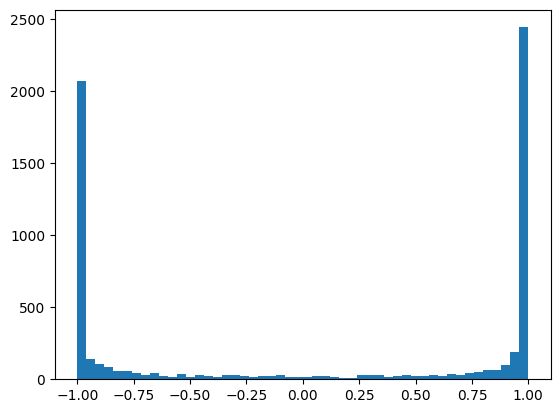

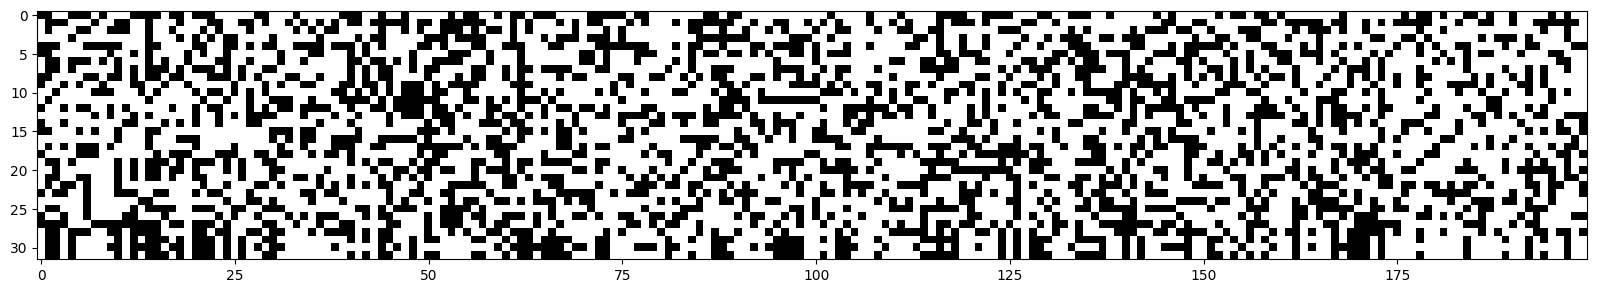

In [ ]:
# this breaks and leaves training loop. plots graphs after 1 iteration
fm_debug = FirstModel(debug_h=True)
fm_debug.train()

18:40 we want to see how often h is in flat area, say greater than 0.99 which is effectively 1.
18:57 the black white image is only for 1 batch. How about the other batches? And can we automate the detection of this per batch. There must be SOME dead neurons in all the batches? Is it true that if no neuron is not dead, where dead is a fn of the weight and bias then it is never dead?
19:40 in all these cases the backward gradient would get destroyed.


Working back from the logits lets look at the hidden layer,h. This is the second problem, if you look at initial value of h, moany are 1 or -1. 22:07 the relu dead neuron you see if during init W and are set to where the neuron is the flat region of the relu, the weights will never leran. Also can happed during optimizztion where it gets knocked into flat region. once 0 then nothing can bring it out? Verify with test because 0* something = 0.

device = device(type='cpu')
vocab_size:27
Xtr:torch.Size([182625, 3]) Ytr:torch.Size([182625])
Xdev:torch.Size([22655, 3]) Ydev:torch.Size([22655])
Xte:torch.Size([22866, 3]) Yte:torch.Size([22866])
sum: sum(p.nelement() for p in self.parameteres)
elapsed time:0.06697773933410645
train 3.3015224933624268
val 3.3015763759613037


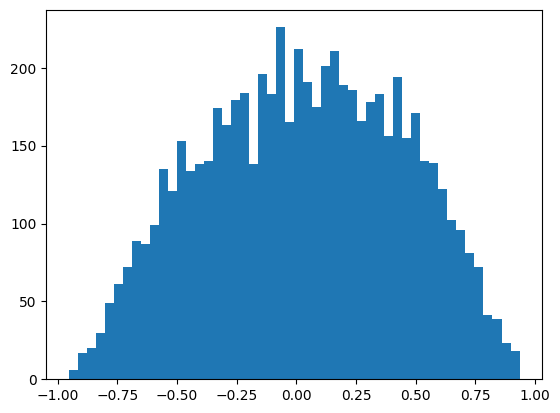

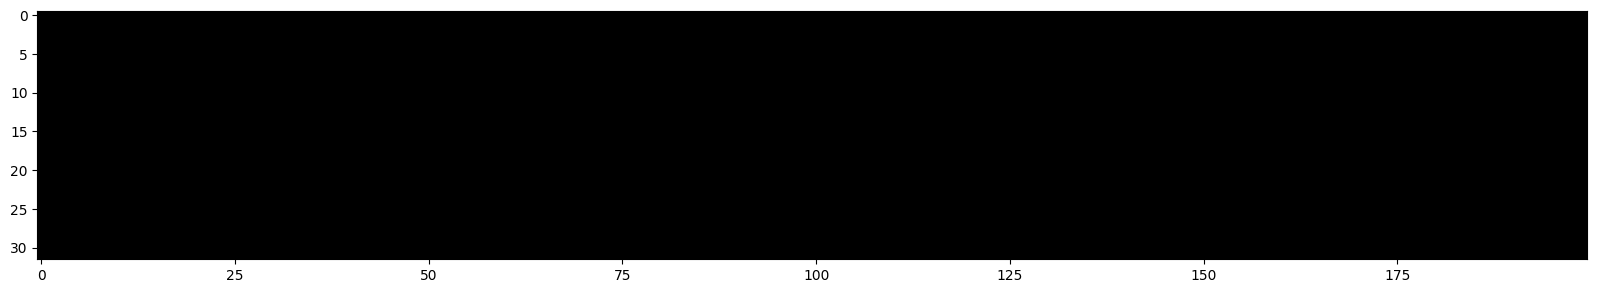

In [ ]:
class FirstModel_V1:
  def __init__(self, debug_h=False):
    self.n_embed = 10
    self.n_hidden = 200
    self.block_size = 3
    self.device = self.enable_cuda()
    self.vocab_size, self.stoi, self.itos, self.words = self.get_data()
    self.split_data()
    self.debug_h = debug_h
    self.g = torch.Generator(device=self.device).manual_seed(2147483647)
    #
    self.C = torch.randn(( self.vocab_size, self.n_embed),                 generator=self.g, device = self.device)
    self.W1 = torch.randn((self.n_embed * self.block_size, self.n_hidden), generator=self.g, device = self.device) * .1
    self.b1 = torch.randn((self.n_hidden),                            generator=self.g, device = self.device) * .01
    self.W2 = torch.randn((self.n_hidden, self.vocab_size),           generator=self.g, device = self.device) * 0.01
    self.b2 = torch.randn( self.vocab_size,                           generator=self.g, device = self.device) * 0.
    self.parameters = [self.C, self.W1, self.b1, self.W2, self.b2]
    print(f'sum: sum(p.nelement() for p in self.parameteres)')

    for p in self.parameters:
      p.requires_grad = True

  def enable_cuda(self):
    if torch.cuda.is_available():
      device = torch.device("cuda")        # NVIDIA GPU
    elif torch.backends.mps.is_available():
      device = torch.device("mps")         # Apple silicon GPU
    else:
      device = torch.device("cpu")         # CPU
    print(f"{device = }")
    return device

  def get_data(self):
    words = open('/content/drive/MyDrive/makemore/names.txt').read().splitlines()
    # build the vocabulary of characters and mappings to/from integers
    chars = sorted(list(set(''.join(words))))
    stoi = {s:i+1 for i,s in enumerate(chars)}
    stoi['.'] = 0
    itos = {i:s for s,i in stoi.items()}
    vocab_size = len(itos)
    print(f'vocab_size:{vocab_size}')
    return vocab_size, stoi, itos, words

  def build_dataset(self, words):
    # context length: how many characters do we take to predict the next one?
    X, Y = [], []
    for w in words:
      context = [0] * self.block_size
      for ch in w + '.':
        ix = self.stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix] # crop and append

    X = torch.tensor(X, device = self.device)
    Y = torch.tensor(Y, device = self.device)
    return X, Y

  def split_data(self):
    random.seed(42)
    random.shuffle(self.words)

    n1 = int(0.8*len(self.words))
    n2 = int(0.9*len(self.words))

    self.Xtr,  self.Ytr  = self.build_dataset(self.words[:n1])     # 80%
    self.Xdev, self.Ydev = self.build_dataset(self.words[n1:n2])   # 10%
    self.Xte,  self.Yte  = self.build_dataset(self.words[n2:])     # 10%
    print(f"Xtr:{self.Xtr.shape} Ytr:{self.Ytr.shape}")
    print(f"Xdev:{self.Xdev.shape} Ydev:{self.Ydev.shape}")
    print(f"Xte:{self.Xte.shape} Yte:{self.Yte.shape}")


  def train(self):
    self.max_steps = 200000
    #self.max_steps=2
    self.batch_size = 32
    self.lossi = []
    start_time = time.time()

    for i in range(self.max_steps):
      #minibatch
      ix = torch.randint(0, self.Xtr.shape[0], (self.batch_size, ), generator=self.g , device = self.device)
      self.Xb, self.Yb = self.Xtr[ix], self.Ytr[ix]
      #print(f"Xb device:{self.Xb.device} Yb device:{self.Yb.device}")
      # forward
      self.emb = self.C[self.Xb]
      #print(f"self.emb device:{self.emb.device}")
      self.embcat = self.emb.view(self.emb.shape[0], -1)
      #print(f"self.embcat device:{self.embcat.device}")

      self.hpreact = self.embcat @ self.W1 + self.b1
      #print(f"self.hpreact device:{self.hpreact.device}")

      self.h = torch.tanh(self.hpreact)
      #print(f"self.h device:{self.h.device}")
      if self.debug_h:
        plt.hist(self.h.view(-1).tolist(),50)

        '''find dead neurons'''
        plt.figure(figsize=(20,10))
        plt.imshow(self.h.abs() > 0.99,cmap='gray', interpolation='nearest')
        break

      self.logits = self.h @ self.W2 + self.b2
      #print(f"self.logits device:{self.logits.device}")
      self.loss = F.cross_entropy(self.logits, self.Yb)
      #print(f"self.loss device:{self.loss.device}")

      #backward
      for p in self.parameters:
        p.grad = None
      self.loss.backward()
      # update
      lr = 0.1 if i < 100000 else 0.01
      for p in self.parameters:
        p.data += -lr * p.grad

      if i % 10000 == 0:
        print(f'{i:7d}/{self.max_steps:7d}:{self.loss.item():.4f}')
      if i == 1:
        print("logits are closer to 0 from karpathy makemroe3 YT video time index:10.20. ")
        #print(f"logits:{self.logits}, sum:{self.logits.sum(keepdim=True)}")
        print(f"see how close logits are to 0, mean:{self.logits.mean()}")


      self.lossi.append(self.loss.log10().item()) # do we need to detach from GPU? prob not
    print(f"elapsed time:{time.time() - start_time}")

  def visualize(self):
    plt.plot(self.lossi)


  def split_loss(self, split):
    ''' generate output turn off gradients with context manager, with torch.no_grad():,
    run forward pass and disable dropout, use running stats in batchnorm '''
    x, y = {
        'train':(self.Xtr, self.Ytr),
        'val':(self.Xdev, self.Ydev),
        'test':(self.Xte, self.Yte),
    }[split]
    # compute forward pass with batch norm set to running mean and dropout disabled
    # none of that applies to this simple MLP
    emb = self.C[x] # N, block_size, n_embd
    embcat = emb.view(emb.shape[0], -1) # conct to N, block_size * n_embd
    h = torch.tanh(embcat @ self.W1 + self.b1)
    logits = h @ self.W2 + self.b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

fm = FirstModel_V1(debug_h=True)
fm.train()
fm.visualize()
fm.split_loss("train")
fm.split_loss("val")
# the first loss  0/ 200000:4.2326 isnt 28.5



Note the distribution is no longer peaked at -1 and +1. Is more well distributed

device = device(type='cpu')
vocab_size:27
Xtr:torch.Size([182625, 3]) Ytr:torch.Size([182625])
Xdev:torch.Size([22655, 3]) Ydev:torch.Size([22655])
Xte:torch.Size([22866, 3]) Yte:torch.Size([22866])
sum: sum(p.nelement() for p in self.parameteres)
      0/ 200000:3.3069
logits are closer to 0 from karpathy makemroe3 YT video time index:10.20. 
see how close logits are to 0, mean:0.004076831508427858
  10000/ 200000:2.1900
  20000/ 200000:2.2707
  30000/ 200000:2.4296
  40000/ 200000:1.9041
  50000/ 200000:2.3865
  60000/ 200000:2.3392
  70000/ 200000:2.0873
  80000/ 200000:2.2595
  90000/ 200000:2.1146
 100000/ 200000:1.8817
 110000/ 200000:2.1622
 120000/ 200000:1.8919
 130000/ 200000:2.3128
 140000/ 200000:2.3481
 150000/ 200000:2.1759
 160000/ 200000:1.8034
 170000/ 200000:1.7760
 180000/ 200000:1.8992
 190000/ 200000:1.8666
elapsed time:112.99010944366455
train 2.05790114402771
val 2.113706588745117


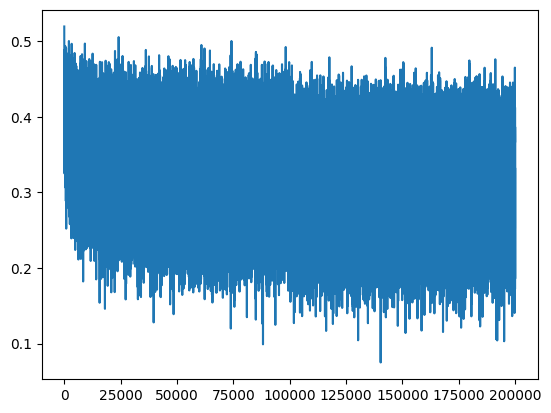

In [ ]:
fm = FirstModel_V1(debug_h=False)
fm.train()
fm.visualize()
fm.split_loss("train")
fm.split_loss("val")

27:13 we are working with 1 layer so the optimization is forgiving. Eventually teh network got the rigth result. This is not the case in general. at 50 layers teh network may not train at all if the initializaiton isnt good enough. The deeper and more complicated the network is the less forgiving it is to some of these errors.

device = device(type='cpu')
vocab_size:27
Xtr:torch.Size([182625, 3]) Ytr:torch.Size([182625])
Xdev:torch.Size([22655, 3]) Ydev:torch.Size([22655])
Xte:torch.Size([22866, 3]) Yte:torch.Size([22866])
sum: sum(p.nelement() for p in self.parameteres)
elapsed time:0.06346726417541504
train 3.3057639598846436
val 3.305715560913086


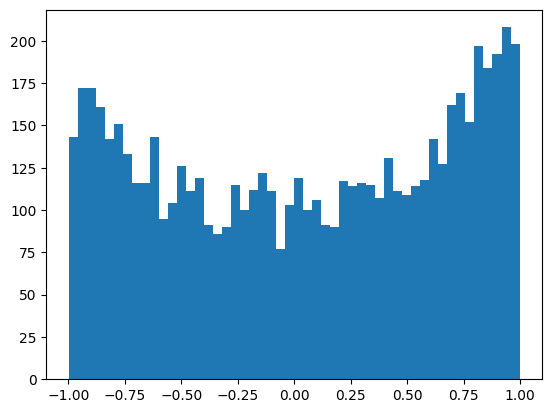

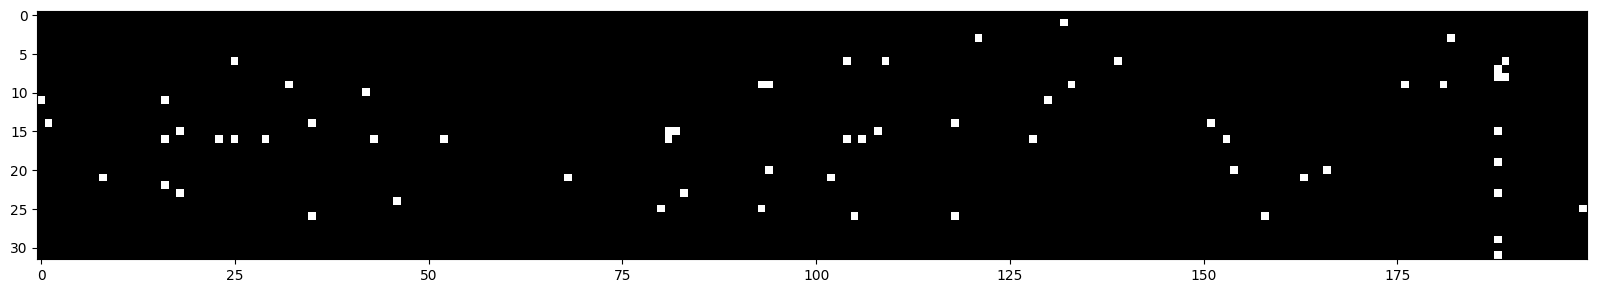

In [ ]:
class FirstModel_V2:
  def __init__(self, debug_h=False):
    self.n_embed = 10
    self.n_hidden = 200
    self.block_size = 3
    self.device = self.enable_cuda()
    self.vocab_size, self.stoi, self.itos, self.words = self.get_data()
    self.split_data()
    self.debug_h = debug_h
    self.g = torch.Generator(device=self.device).manual_seed(2147483647)
    #
    self.C = torch.randn(( self.vocab_size, self.n_embed),                 generator=self.g, device = self.device)
    self.W1 = torch.randn((self.n_embed * self.block_size, self.n_hidden), generator=self.g, device = self.device) * .2
    self.b1 = torch.randn((self.n_hidden),                            generator=self.g, device = self.device) * .01
    self.W2 = torch.randn((self.n_hidden, self.vocab_size),           generator=self.g, device = self.device) * 0.01
    self.b2 = torch.randn( self.vocab_size,                           generator=self.g, device = self.device) * 0.
    self.parameters = [self.C, self.W1, self.b1, self.W2, self.b2]
    print(f'sum: sum(p.nelement() for p in self.parameteres)')

    for p in self.parameters:
      p.requires_grad = True

  def enable_cuda(self):
    if torch.cuda.is_available():
      device = torch.device("cuda")        # NVIDIA GPU
    elif torch.backends.mps.is_available():
      device = torch.device("mps")         # Apple silicon GPU
    else:
      device = torch.device("cpu")         # CPU
    print(f"{device = }")
    return device

  def get_data(self):
    words = open('/content/drive/MyDrive/makemore/names.txt').read().splitlines()
    # build the vocabulary of characters and mappings to/from integers
    chars = sorted(list(set(''.join(words))))
    stoi = {s:i+1 for i,s in enumerate(chars)}
    stoi['.'] = 0
    itos = {i:s for s,i in stoi.items()}
    vocab_size = len(itos)
    print(f'vocab_size:{vocab_size}')
    return vocab_size, stoi, itos, words

  def build_dataset(self, words):
    # context length: how many characters do we take to predict the next one?
    X, Y = [], []
    for w in words:
      context = [0] * self.block_size
      for ch in w + '.':
        ix = self.stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix] # crop and append

    X = torch.tensor(X, device = self.device)
    Y = torch.tensor(Y, device = self.device)
    return X, Y

  def split_data(self):
    random.seed(42)
    random.shuffle(self.words)

    n1 = int(0.8*len(self.words))
    n2 = int(0.9*len(self.words))

    self.Xtr,  self.Ytr  = self.build_dataset(self.words[:n1])     # 80%
    self.Xdev, self.Ydev = self.build_dataset(self.words[n1:n2])   # 10%
    self.Xte,  self.Yte  = self.build_dataset(self.words[n2:])     # 10%
    print(f"Xtr:{self.Xtr.shape} Ytr:{self.Ytr.shape}")
    print(f"Xdev:{self.Xdev.shape} Ydev:{self.Ydev.shape}")
    print(f"Xte:{self.Xte.shape} Yte:{self.Yte.shape}")


  def train(self):
    self.max_steps = 200000
    #self.max_steps=2
    self.batch_size = 32
    self.lossi = []
    start_time = time.time()

    for i in range(self.max_steps):
      #minibatch
      ix = torch.randint(0, self.Xtr.shape[0], (self.batch_size, ), generator=self.g , device = self.device)
      self.Xb, self.Yb = self.Xtr[ix], self.Ytr[ix]
      #print(f"Xb device:{self.Xb.device} Yb device:{self.Yb.device}")
      # forward
      self.emb = self.C[self.Xb]
      #print(f"self.emb device:{self.emb.device}")
      self.embcat = self.emb.view(self.emb.shape[0], -1)
      #print(f"self.embcat device:{self.embcat.device}")

      self.hpreact = self.embcat @ self.W1 + self.b1
      #print(f"self.hpreact device:{self.hpreact.device}")

      self.h = torch.tanh(self.hpreact)
      #print(f"self.h device:{self.h.device}")
      if self.debug_h:
        plt.hist(self.h.view(-1).tolist(),50)

        '''find dead neurons'''
        plt.figure(figsize=(20,10))
        plt.imshow(self.h.abs() > 0.99,cmap='gray', interpolation='nearest')
        break

      self.logits = self.h @ self.W2 + self.b2
      #print(f"self.logits device:{self.logits.device}")
      self.loss = F.cross_entropy(self.logits, self.Yb)
      #print(f"self.loss device:{self.loss.device}")

      #backward
      for p in self.parameters:
        p.grad = None
      self.loss.backward()
      # update
      lr = 0.1 if i < 100000 else 0.01
      for p in self.parameters:
        p.data += -lr * p.grad

      if i % 10000 == 0:
        print(f'{i:7d}/{self.max_steps:7d}:{self.loss.item():.4f}')
      if i == 1:
        print("logits are closer to 0 from karpathy makemroe3 YT video time index:10.20. ")
        #print(f"logits:{self.logits}, sum:{self.logits.sum(keepdim=True)}")
        print(f"see how close logits are to 0, mean:{self.logits.mean()}")


      self.lossi.append(self.loss.log10().item()) # do we need to detach from GPU? prob not
    print(f"elapsed time:{time.time() - start_time}")

  def visualize(self):
    plt.plot(self.lossi)

  def split_loss(self, split):
    ''' generate output turn off gradients with context manager, with torch.no_grad():,
    run forward pass and disable dropout, use running stats in batchnorm '''
    x, y = {
        'train':(self.Xtr, self.Ytr),
        'val':(self.Xdev, self.Ydev),
        'test':(self.Xte, self.Yte),
    }[split]
    # compute forward pass with batch norm set to running mean and dropout disabled
    # none of that applies to this simple MLP
    emb = self.C[x] # N, block_size, n_embd
    embcat = emb.view(emb.shape[0], -1) # conct to N, block_size * n_embd
    h = torch.tanh(embcat @ self.W1 + self.b1)
    logits = h @ self.W2 + self.b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

fm = FirstModel_V2(debug_h=True)
fm.train()
fm.visualize()
fm.split_loss("train")
fm.split_loss("val")
# the first loss  0/ 200000:4.2326 isnt 28.5



nobody sets these by hand. There is a framework for weight and bias initialization.

<h2> Test how to detect vanishing gradients in MLP </h2>
<p>Bad initialization and high learning rates can create dead neurons which means when a weight is 0 anything times 0 is 0 so the neuron is dead. Or a very small value? How about eliminating 0s and making evrything super small number? This is what skip connections do. They make sure you can never get 0.  Vanishing gradients lead to dead neurons. </p>


<h2>Demo normalizing by fan-in</h2>

tensor(-0.0026) tensor(3.1537)
tensor(-0.0008) tensor(0.9973)


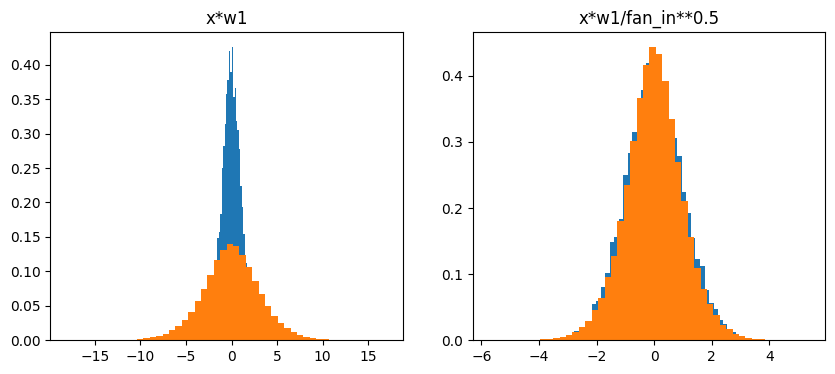

In [ ]:
#https://arxiv.org/abs/1502.01852
#divide weights by sqrt(fanin) to get unit variance and zero mean
#they have to add a factor of 2 because of the relu. The relu sets evrything
#less than 0 to 0 and a linear gain for the positive numbers. The paper finds that
#because you throw away 1/2 of the distribution you have to compensate by adding a
#gain. hence the sqrt(2/fan_in)). Karpathy eliminates the 2 in his mod of the Kaiming init.
#the kaiming init was originally developed for CNNs.
# 33:27 Makemore3 YT video.
# The paper finds need to adjust the backward prop direction also. paper finds
# if the forward
# pass is initialized then the backward pass is approximately initialized up to
# the size of the hidden neurons in the early and late layer. implemented in torch.nn.init.kaiming_normal
# karpathy: in his opinion the most common. depending on nonlinearity you have to
# calculate a slightly different gain. Q) does batch normalization change this?
# Intuitively why do we need the gain? Because the activation fns like tanh squash
# the range so to get the range back we multiply. 7yo it was important to initialize
# with this, but now with batch norm and residual connections not as important to get
# kaiming init exactly right and NN will still converge.
# FROM the kaiming paper the gain for tanh is 5/3. the fan_in is 30, n_embed=10 and context
# window is 3, 10*3 =30. Gain 30*(5/3) = 0.3. Karpathy guessed 0.2 which was close enough
# q) how can you tell if a given initialization is better?
#
#
import torch
import  matplotlib.pyplot as plt

fan_in = 10
x = torch.randn(1000, fan_in)
w1 = torch.randn((fan_in, 200) )
w2 = w1 / fan_in**0.5
y = x @ w1
y1 = x @ w2
print(y.mean(), y.std())
# can see y1 is closer to 0 mean and 1 variance
print(y1.mean(), y1.std())

# subplot(#rows, #numcols, (width inch, height inch)
fig, axes = plt.subplots(1,2,figsize=(10,4))

axes[0].hist(x.view(-1).tolist(), 50, density=True)
axes[0].set_title("x*w1")

axes[1].set_title("x*w1/fan_in**0.5")
axes[0].hist(y.view(-1).tolist(), 50, density=True)

axes[1].hist(x.view(-1).tolist(), 50, density=True)
axes[1].hist(y1.view(-1).tolist(), 50, density=True)

plt.show()

Types of initializatoins
<li>xavier</li>
<li>kaiming</li>
<li>orthogonal: preserves norm. helps with deeper nets</li>
<li>zero init, worst, vanishing gradients and dead neurons</li>


<h2>Batch Normalization </h2>
2015: https://arxiv.org/abs/1502.03167
<p>Starting from preact layer we dont want the values to be too small because the tanh wont do anything and we dont want the values to be 1 because the tanh is saturated. Want them to be roughly gaussian, 0 mean and 1 std deviation. BN controls the scale of the activations. Add throughout the NN. The stability of BN introduces a dependency on the batch sampling leading to strange results.  THere is a jitter on h and logits per batch after the applicaiton of BN on preact.  </p>
<p>The batches are coupled mathematically in the forward pass and it leads to lots of bugs</p>

<li>layer normalization</li>
<li>instance normalization</li>
<li>group normalization</li>

<p>for distributed training sync the batch norm across all devices. </p>

<p>For inference or during split_loss we use the batch mean and std dev calculated over the entire training set. </p>

<p>Nobody wants to run 2 passes through the training set so the paper introduces an idea on how to estimate the training set batch norm and std. deviation across teh training set during training stage. </p>

cpu
device = device(type='cpu')
vocab_size:27
Xtr:torch.Size([182625, 3]) Ytr:torch.Size([182625])
Xdev:torch.Size([22655, 3]) Ydev:torch.Size([22655])
Xte:torch.Size([22866, 3]) Yte:torch.Size([22866])
sum: sum(p.nelement() for p in self.parameteres)
      0/ 200000:3.3147
logits are closer to 0 from karpathy makemroe3 YT video time index:10.20. 
see how close logits are to 0, mean:-0.0005443622940219939
  10000/ 200000:2.1426
  20000/ 200000:2.3128
  30000/ 200000:2.4206
  40000/ 200000:1.9814
  50000/ 200000:2.3441
  60000/ 200000:2.5317
  70000/ 200000:2.0418
  80000/ 200000:2.3075
  90000/ 200000:2.1127
 100000/ 200000:1.9335
 110000/ 200000:2.3863
 120000/ 200000:1.9474
 130000/ 200000:2.4764
 140000/ 200000:2.3550
 150000/ 200000:2.2926
 160000/ 200000:2.0620
 170000/ 200000:1.8535
 180000/ 200000:1.9758
 190000/ 200000:1.8365
elapsed time:165.95115566253662
train 2.7605831623077393
val 2.781522512435913


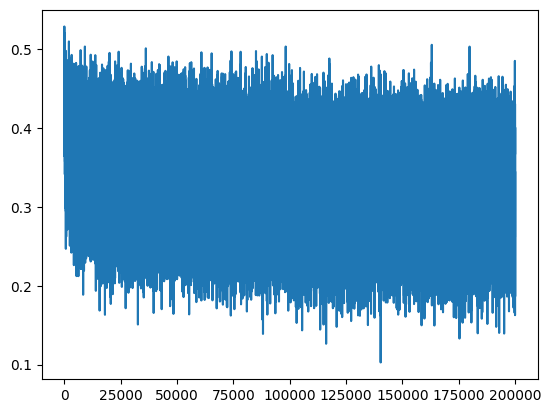

In [ ]:
import torch
import matplotlib.pyplot as plt
import random
import time

class FirstModel_BN:
  def __init__(self, debug_h=False):
    self.n_embed = 10
    self.n_hidden = 200
    self.block_size = 3
    self.device = self.enable_cuda()
    self.vocab_size, self.stoi, self.itos, self.words = self.get_data()
    self.split_data()

    self.debug_h = debug_h
    self.g = torch.Generator(device=self.device).manual_seed(2147483647)
    #
    self.bngain = torch.ones((1, self.n_hidden))
    self.bnbias = torch.zeros((1, self.n_hidden))

    self.C = torch.randn(( self.vocab_size, self.n_embed),                 generator=self.g, device = self.device)
    self.W1 = torch.randn((self.n_embed * self.block_size, self.n_hidden), generator=self.g, device = self.device) * .2
    self.b1 = torch.randn((self.n_hidden),                            generator=self.g, device = self.device) * .01
    self.W2 = torch.randn((self.n_hidden, self.vocab_size),           generator=self.g, device = self.device) * 0.01
    self.b2 = torch.randn( self.vocab_size,                           generator=self.g, device = self.device) * 0.
    self.parameters = [self.C, self.W1, self.b1, self.W2, self.b2]
    print(f'sum: sum(p.nelement() for p in self.parameteres)')
    self.bnmean, self.bnstd = self.calc()

    for p in self.parameters:
      p.requires_grad = True

  def calc(self):
    with torch.no_grad():
      emb = self.C[self.Xtr]
      embcat = emb.view(emb.shape[0], -1)
      hpreact = embcat @ self.W1 + self.b1
      bnmean = hpreact.mean(0, keepdim=True)
      bnstd = hpreact.std(0, keepdim = True)
      return bnmean, bnstd

  def enable_cuda(self):
    if torch.cuda.is_available():
      print("cuda")
      device = torch.device("cuda")        # NVIDIA GPU
    elif torch.backends.mps.is_available():
      device = torch.device("mps")         # Apple silicon GPU
    else:
      print("cpu")
      device = torch.device("cpu")         # CPU
    print(f"{device = }")
    return device

  def get_data(self):
    words = open('/content/drive/MyDrive/makemore/names.txt').read().splitlines()
    # build the vocabulary of characters and mappings to/from integers
    chars = sorted(list(set(''.join(words))))
    stoi = {s:i+1 for i,s in enumerate(chars)}
    stoi['.'] = 0
    itos = {i:s for s,i in stoi.items()}
    vocab_size = len(itos)
    print(f'vocab_size:{vocab_size}')
    return vocab_size, stoi, itos, words

  def build_dataset(self, words):
    # context length: how many characters do we take to predict the next one?
    X, Y = [], []
    for w in words:
      context = [0] * self.block_size
      for ch in w + '.':
        ix = self.stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix] # crop and append

    X = torch.tensor(X, device = self.device)
    Y = torch.tensor(Y, device = self.device)
    return X, Y

  def split_data(self):
    random.seed(42)
    random.shuffle(self.words)

    n1 = int(0.8*len(self.words))
    n2 = int(0.9*len(self.words))

    self.Xtr,  self.Ytr  = self.build_dataset(self.words[:n1])     # 80%
    self.Xdev, self.Ydev = self.build_dataset(self.words[n1:n2])   # 10%
    self.Xte,  self.Yte  = self.build_dataset(self.words[n2:])     # 10%
    print(f"Xtr:{self.Xtr.shape} Ytr:{self.Ytr.shape}")
    print(f"Xdev:{self.Xdev.shape} Ydev:{self.Ydev.shape}")
    print(f"Xte:{self.Xte.shape} Yte:{self.Yte.shape}")


  def train(self):
    self.max_steps = 200000
    #self.max_steps=2
    self.batch_size = 32
    self.lossi = []
    start_time = time.time()

    for i in range(self.max_steps):
      #minibatch
      ix = torch.randint(0, self.Xtr.shape[0], (self.batch_size, ), generator=self.g , device = self.device)
      self.Xb, self.Yb = self.Xtr[ix], self.Ytr[ix]
      #print(f"Xb device:{self.Xb.device} Yb device:{self.Yb.device}")
      # forward
      self.emb = self.C[self.Xb]
      #print(f"self.emb device:{self.emb.device}")
      self.embcat = self.emb.view(self.emb.shape[0], -1)
      #print(f"self.embcat device:{self.embcat.device}")

      self.hpreact = self.embcat @ self.W1 + self.b1
      hp_react_mean = self.hpreact.mean(0, keepdim=True)
      hp_react_std_dev = self.hpreact.std(0, keepdim=True)
      self.hpreact = self.bngain * (self.hpreact - hp_react_mean)/hp_react_std_dev

      #print(f"self.hpreact device:{self.hpreact.device}")

      self.h = torch.tanh(self.hpreact)
      #print(f"self.h device:{self.h.device}")
      if self.debug_h:
        plt.hist(self.h.view(-1).tolist(),50)

        '''find dead neurons'''
        plt.figure(figsize=(20,10))
        plt.imshow(self.h.abs() > 0.99,cmap='gray', interpolation='nearest')
        break

      self.logits = self.h @ self.W2 + self.b2
      #print(f"self.logits device:{self.logits.device}")
      self.loss = F.cross_entropy(self.logits, self.Yb)
      #print(f"self.loss device:{self.loss.device}")

      #backward
      for p in self.parameters:
        p.grad = None
      self.loss.backward()
      # update
      lr = 0.1 if i < 100000 else 0.01
      for p in self.parameters:
        p.data += -lr * p.grad

      if i % 10000 == 0:
        print(f'{i:7d}/{self.max_steps:7d}:{self.loss.item():.4f}')
      if i == 1:
        print("logits are closer to 0 from karpathy makemroe3 YT video time index:10.20. ")
        #print(f"logits:{self.logits}, sum:{self.logits.sum(keepdim=True)}")
        print(f"see how close logits are to 0, mean:{self.logits.mean()}")


      self.lossi.append(self.loss.log10().item()) # do we need to detach from GPU? prob not
    print(f"elapsed time:{time.time() - start_time}")

  def visualize(self):
    plt.plot(self.lossi)

  def split_loss(self, split):
    ''' generate output turn off gradients with context manager, with torch.no_grad():,
    run forward pass and disable dropout, use running stats in batchnorm '''
    x, y = {
        'train':(self.Xtr, self.Ytr),
        'val':(self.Xdev, self.Ydev),
        'test':(self.Xte, self.Yte),
    }[split]
    # compute forward pass with batch norm set to running mean and dropout disabled
    # none of that applies to this simple MLP
    emb = self.C[x] # N, block_size, n_embd
    embcat = emb.view(emb.shape[0], -1) # conct to N, block_size * n_embd
    hpreact = embcat @ self.W1 + self.b1
    hpreact = self.bngain * (hpreact - self.bnmean)/(self.bnstd + self.bnbias)

    h = torch.tanh(embcat @ self.W1 + self.b1)
    logits = h @ self.W2 + self.b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

fm = FirstModel_BN(debug_h=False)
fm.train()
fm.visualize()
fm.split_loss("train")
fm.split_loss("val")
# the first loss  0/ 200000:4.2326 isnt 28.5



<h2>More batch norm notes</h2>
<p>1:12:26 mommentum in batch norm. If you have a small batch size like 32 then there is a lot of varitaion in the mean and std between each 32 size batch. A momentum of .001 better for smaller batch but ifyou have bigger batch size you dont get as much jitter so .1 which is pytorch default is better. .001 the smaller value allows the batch variation to settle. A bigger one does not and if you dont settle it wont converge to the actual mean and std of teh entire training set. Affine in pytorch batch norm 1d is always set to true. He is not sure why it would be set to false. 1:13:47 set track_running_stats=False if you dont want to calc running states, if want BN after training dont need runnign stats? Verify. Does each layer have running_stats enabled in Nvidia NEMO? </p>

<p>summary 1:14:46</p>
<li>Hockey stick learning not efficient wasting training cycles in early part of curve</li>
<li>control activations. the activations have property where they squash to 0 or explode to infinity. Control this to make everything homogenenous throughout NN> Roughly gaussian acttivations throughout the NN</li>
<li>If we want gaussian activation how do we scale these weight and bias initializations throughout the NN? We did an example where manually adjusted the constants to set teh weights and biases on initialization to keep starting point close to final loss. Problem is this is not possibe when there are many layers in a transformer. Use batch normalization layer to compute average and running avg estimate which is equivalent to centering and normalizing the data. Problem from this is how to readust when doing inference? Add a running mean and std durning training time. Batch N causes lot of bugs by coupling examples in the forward pass of the NN.  </li>
<li></li>

cpu
device = device(type='cpu')
vocab_size:27
Xtr:torch.Size([182625, 3]) Ytr:torch.Size([182625])
Xdev:torch.Size([22655, 3]) Ydev:torch.Size([22655])
Xte:torch.Size([22866, 3]) Yte:torch.Size([22866])
sum: sum(p.nelement() for p in self.parameteres)
      0/ 200000:3.3147
logits are closer to 0 from karpathy makemroe3 YT video time index:10.20. 
see how close logits are to 0, mean:-0.0005443622940219939
  10000/ 200000:2.1426
  20000/ 200000:2.3128
  30000/ 200000:2.4206
  40000/ 200000:1.9814
  50000/ 200000:2.3441
  60000/ 200000:2.5317
  70000/ 200000:2.0418
  80000/ 200000:2.3075
  90000/ 200000:2.1127
 100000/ 200000:1.9335
 110000/ 200000:2.3863
 120000/ 200000:1.9474
 130000/ 200000:2.4764
 140000/ 200000:2.3550
 150000/ 200000:2.2926
 160000/ 200000:2.0620
 170000/ 200000:1.8535
 180000/ 200000:1.9758
 190000/ 200000:1.8365
elapsed time:167.78468251228333
train 2.7605831623077393
val 2.781522512435913


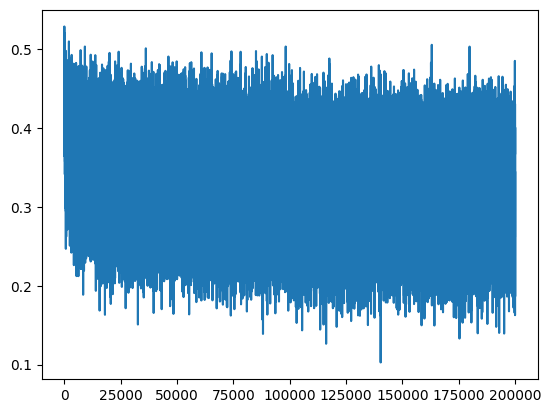

In [ ]:
import torch
import matplotlib.pyplot as plt
import random
import time

class FirstModel_BN_est_trainingset_norm:
  def __init__(self, debug_h=False):
    self.n_embed = 10
    self.n_hidden = 200
    self.block_size = 3
    self.device = self.enable_cuda()
    self.vocab_size, self.stoi, self.itos, self.words = self.get_data()
    self.split_data()

    self.debug_h = debug_h
    self.g = torch.Generator(device=self.device).manual_seed(2147483647)
    #
    self.bngain = torch.ones((1, self.n_hidden))
    self.bnbias = torch.zeros((1, self.n_hidden))
    self.bnmean_running = torch.zeros((1, self.n_hidden))
    self.bnstd_running = torch.ones((1, self.n_hidden))

    self.C = torch.randn(( self.vocab_size, self.n_embed),                 generator=self.g, device = self.device)
    self.W1 = torch.randn((self.n_embed * self.block_size, self.n_hidden), generator=self.g, device = self.device) * .2
    self.b1 = torch.randn((self.n_hidden),                            generator=self.g, device = self.device) * .01
    self.W2 = torch.randn((self.n_hidden, self.vocab_size),           generator=self.g, device = self.device) * 0.01
    self.b2 = torch.randn( self.vocab_size,                           generator=self.g, device = self.device) * 0.
    self.parameters = [self.C, self.W1, self.b1, self.W2, self.b2]
    print(f'sum: sum(p.nelement() for p in self.parameteres)')
    self.bnmean, self.bnstd = self.calc()

    for p in self.parameters:
      p.requires_grad = True

  def calc(self):
    with torch.no_grad():
      emb = self.C[self.Xtr]
      embcat = emb.view(emb.shape[0], -1)
      hpreact = embcat @ self.W1 + self.b1
      bnmean = hpreact.mean(0, keepdim=True)
      bnstd = hpreact.std(0, keepdim = True)
      return bnmean, bnstd

  def enable_cuda(self):
    if torch.cuda.is_available():
      print("cuda")
      device = torch.device("cuda")        # NVIDIA GPU
    elif torch.backends.mps.is_available():
      device = torch.device("mps")         # Apple silicon GPU
    else:
      print("cpu")
      device = torch.device("cpu")         # CPU
    print(f"{device = }")
    return device

  def get_data(self):
    words = open('/content/drive/MyDrive/makemore/names.txt').read().splitlines()
    # build the vocabulary of characters and mappings to/from integers
    chars = sorted(list(set(''.join(words))))
    stoi = {s:i+1 for i,s in enumerate(chars)}
    stoi['.'] = 0
    itos = {i:s for s,i in stoi.items()}
    vocab_size = len(itos)
    print(f'vocab_size:{vocab_size}')
    return vocab_size, stoi, itos, words

  def build_dataset(self, words):
    # context length: how many characters do we take to predict the next one?
    X, Y = [], []
    for w in words:
      context = [0] * self.block_size
      for ch in w + '.':
        ix = self.stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix] # crop and append

    X = torch.tensor(X, device = self.device)
    Y = torch.tensor(Y, device = self.device)
    return X, Y

  def split_data(self):
    random.seed(42)
    random.shuffle(self.words)

    n1 = int(0.8*len(self.words))
    n2 = int(0.9*len(self.words))

    self.Xtr,  self.Ytr  = self.build_dataset(self.words[:n1])     # 80%
    self.Xdev, self.Ydev = self.build_dataset(self.words[n1:n2])   # 10%
    self.Xte,  self.Yte  = self.build_dataset(self.words[n2:])     # 10%
    print(f"Xtr:{self.Xtr.shape} Ytr:{self.Ytr.shape}")
    print(f"Xdev:{self.Xdev.shape} Ydev:{self.Ydev.shape}")
    print(f"Xte:{self.Xte.shape} Yte:{self.Yte.shape}")


  def train(self):
    self.max_steps = 200000
    #self.max_steps=2
    self.batch_size = 32
    self.lossi = []
    start_time = time.time()

    for i in range(self.max_steps):
      #minibatch
      ix = torch.randint(0, self.Xtr.shape[0], (self.batch_size, ), generator=self.g , device = self.device)
      self.Xb, self.Yb = self.Xtr[ix], self.Ytr[ix]
      #print(f"Xb device:{self.Xb.device} Yb device:{self.Yb.device}")
      # forward
      self.emb = self.C[self.Xb]
      #print(f"self.emb device:{self.emb.device}")
      self.embcat = self.emb.view(self.emb.shape[0], -1)
      #print(f"self.embcat device:{self.embcat.device}")

      self.hpreact = self.embcat @ self.W1 + self.b1

      bnmeani = self.hpreact.mean(0, keepdim=True)
      bnstdi = self.hpreact.std(0, keepdim=True)

      self.hpreact = self.bngain * (self.hpreact - bnmeani)/bnstdi+self.bnbias
      with torch.no_grad():
        bnmean_running = 0.999 * self.bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * self.bnmean_std + 0.001 * bnstdi
      #print(f"self.hpreact device:{self.hpreact.device}")

      self.h = torch.tanh(self.hpreact)
      #print(f"self.h device:{self.h.device}")
      if self.debug_h:
        plt.hist(self.h.view(-1).tolist(),50)

        '''find dead neurons'''
        plt.figure(figsize=(20,10))
        plt.imshow(self.h.abs() > 0.99,cmap='gray', interpolation='nearest')
        break

      self.logits = self.h @ self.W2 + self.b2
      #print(f"self.logits device:{self.logits.device}")
      self.loss = F.cross_entropy(self.logits, self.Yb)
      #print(f"self.loss device:{self.loss.device}")

      #backward
      for p in self.parameters:
        p.grad = None
      self.loss.backward()
      # update
      lr = 0.1 if i < 100000 else 0.01
      for p in self.parameters:
        p.data += -lr * p.grad

      if i % 10000 == 0:
        print(f'{i:7d}/{self.max_steps:7d}:{self.loss.item():.4f}')
      if i == 1:
        print("logits are closer to 0 from karpathy makemroe3 YT video time index:10.20. ")
        #print(f"logits:{self.logits}, sum:{self.logits.sum(keepdim=True)}")
        print(f"see how close logits are to 0, mean:{self.logits.mean()}")


      self.lossi.append(self.loss.log10().item()) # do we need to detach from GPU? prob not
    print(f"elapsed time:{time.time() - start_time}")

  def visualize(self):
    plt.plot(self.lossi)

  def split_loss(self, split):
    ''' generate output turn off gradients with context manager, with torch.no_grad():,
    run forward pass and disable dropout, use running stats in batchnorm '''
    x, y = {
        'train':(self.Xtr, self.Ytr),
        'val':(self.Xdev, self.Ydev),
        'test':(self.Xte, self.Yte),
    }[split]
    # compute forward pass with batch norm set to running mean and dropout disabled
    # none of that applies to this simple MLP
    emb = self.C[x] # N, block_size, n_embd
    embcat = emb.view(emb.shape[0], -1) # conct to N, block_size * n_embd
    hpreact = embcat @ self.W1 + self.b1
    hpreact = self.bngain * (hpreact - self.bnmean)/(self.bnstd + self.bnbias)

    h = torch.tanh(embcat @ self.W1 + self.b1)
    logits = h @ self.W2 + self.b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

fm = FirstModel_BN_est_trainingset_norm(debug_h=False)
fm.train()
fm.visualize()
fm.split_loss("train")
fm.split_loss("val")
# the first loss  0/ 200000:4.2326 isnt 28.5



Residual Connections Test

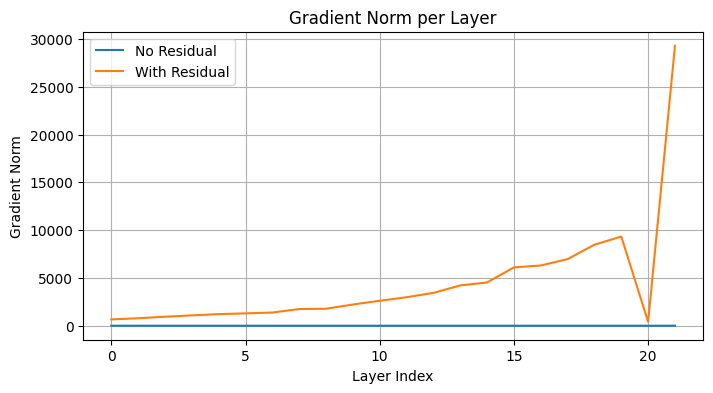

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

class DeepMLP(nn.Module):
    def __init__(self, d_in=100, d_hidden=128, depth=20, residual=False):
        super().__init__()
        self.residual = residual
        self.layers = nn.ModuleList()
        for _ in range(depth):
            self.layers.append(nn.Linear(d_hidden, d_hidden))
        self.input_layer = nn.Linear(d_in, d_hidden)
        self.output_layer = nn.Linear(d_hidden, 1)
        self.act = nn.ReLU()

    def forward(self, x):
        x = self.act(self.input_layer(x))
        for layer in self.layers:
            out = self.act(layer(x))
            x = out + x if self.residual else out
        return self.output_layer(x)

def measure_gradients(model):
    grads = []
    for name, p in model.named_parameters():
        if p.requires_grad and "weight" in name:
            grads.append(p.grad.norm().item() if p.grad is not None else 0.0)
    return grads

# Dummy task
torch.manual_seed(0)
x = torch.randn(256, 100)
y = torch.randn(256, 1)
loss_fn = nn.MSELoss()

# Compare models
results = {}
for label, use_res in [("No Residual", False), ("With Residual", True)]:
    model = DeepMLP(residual=use_res)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    # One forward+backward pass
    pred = model(x)
    loss = loss_fn(pred, y)
    loss.backward()
    grads = measure_gradients(model)
    results[label] = grads

# Plot
plt.figure(figsize=(8,4))
for label, grads in results.items():
    plt.plot(grads, label=label)
plt.xlabel("Layer Index")
plt.ylabel("Gradient Norm")
plt.title("Gradient Norm per Layer")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import torch
import torch.nn as nn

import torch
import torch.nn as nn
import torch.optim as optim

# ----- 1. Synthetic Data -----
# y = ReLU(2x + 1) + noise
x = torch.linspace(-5, 5, 100).unsqueeze(1)             # shape: [100, 1]
true_y = torch.relu(2 * x + 1) + 0.1 * torch.randn_like(x)

# ----- 2. Define Model -----
class SimpleReLUModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(1, 1)

    def forward(self, x):
        x = self.linear(x)
        return torch.relu(x)

model = SimpleReLUModel()

# ----- 3. Loss and Optimizer -----
loss_fn = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# ----- 4. Training Loop -----
for epoch in range(200):
    pred = model(x)
    loss = loss_fn(pred, true_y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 20 == 0:
        print(f"Epoch {epoch+1}: Loss = {loss.item():.4f}")

# ----- 5. Show Learned Parameters -----
print("\nLearned weight:", model.linear.weight.item())
print("Learned bias:", model.linear.bias.item())

Epoch 20: Loss = 0.3653
Epoch 40: Loss = 0.0206
Epoch 60: Loss = 0.0135
Epoch 80: Loss = 0.0133
Epoch 100: Loss = 0.0132
Epoch 120: Loss = 0.0132
Epoch 140: Loss = 0.0132
Epoch 160: Loss = 0.0132
Epoch 180: Loss = 0.0131
Epoch 200: Loss = 0.0131

Learned weight: 2.0111443996429443
Learned bias: 0.9745139479637146


Hooks to measure layers and activation memory
Memory usage:
<li>CUDA memory total, match nvidia-smi</li>
<li>Parameter memory</li>
<li>Activation memory</li>
<li>Gradient memory</li>
<li>optimizer memory</li>

<h1>Triton kernels</h1>
vLLM offline mode

<href=https://www.youtube.com/watch?v=E8Mju53VB00&list=PLoROMvodv4rOY23Y0BoGoBGgQ1zmU_MT_&index=6">

In [ ]:
!pip install triton

In [ ]:

import triton
import triton.language as tl
import torch

@triton.jit
def paged_attention_kernel(
    Q_ptr, K_ptr, V_ptr, Out_ptr,
    B, H, L_Q, L_KV, D,
    stride_qb, stride_qh, stride_qd,
    stride_kb, stride_kh, stride_kd,
    stride_vb, stride_vh, stride_vd,
    stride_ob, stride_oh, stride_od,
    BLOCK_D: tl.constexpr,
):
    pid = tl.program_id(axis=0)
    b = pid // H  # batch
    h = pid % H   # head

    offs_d = tl.arange(0, BLOCK_D)

    q_ptrs = Q_ptr + b * stride_qb + h * stride_qh + offs_d * stride_qd
    k_ptrs = K_ptr + b * stride_kb + h * stride_kh + offs_d * stride_kd
    v_ptrs = V_ptr + b * stride_vb + h * stride_vh + offs_d * stride_vd
    o_ptrs = Out_ptr + b * stride_ob + h * stride_oh + offs_d * stride_od

    q = tl.load(q_ptrs)
    k = tl.load(k_ptrs)
    v = tl.load(v_ptrs)

    score = tl.dot(q, k)
    weight = tl.softmax(score)
    out = tl.dot(weight, v)

    tl.store(o_ptrs, out)

# Example usage
B, H, L, D = 1, 1, 32, 64
Q = torch.randn((B, H, L, D), device="cuda")
K = torch.randn((B, H, L, D), device="cuda")
V = torch.randn((B, H, L, D), device="cuda")
Out = torch.empty_like(Q)

paged_attention_kernel[(B * H,)](
    Q, K, V, Out,
    B, H, L, L, D,
    Q.stride(0), Q.stride(1), Q.stride(3),
    K.stride(0), K.stride(1), K.stride(3),
    V.stride(0), V.stride(1), V.stride(3),
    Out.stride(0), Out.stride(1), Out.stride(3),
    BLOCK_D=D,
)